# Data Analysis Search Results

Our analysis centered around comparing these two metrics:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import glob
import time
from collections import Counter
import json
from multiprocessing import Pool

from tqdm import tqdm
from lxml import html
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
from sklearn.utils import resample

from utils import value_counts, calculate_table, calculate_table_not_unique

In [3]:
# inputs
data_dir = '../data/output/datasets/'
fn_search = f'{data_dir}/searches.csv.xz'
fn_products = f'{data_dir}/products.csv.xz'
fn_queries = '../data/input/combined_queries_with_source.csv'
fn_amazon = f'{data_dir}/amazon_private_label.csv.xz'

# intermediary
fn_compare = f'{data_dir}/quality_and_sales_comparisons.csv'

# outputs
output_dir = '../data/output'
table1 = f'{output_dir}/tables/table1-not_always_labelled.csv'
fig2 = f'{output_dir}/figures/fig2-scatter.png'
fig2_csv = f'{output_dir}/figures/fig2-scatter.csv'
fig3a = f'{output_dir}/figures/fig3a-heatmap_amzn.png'
fig3b = f'{output_dir}/figures/fig3b-heatmap-unaffilated.png'
fig3c = f'{output_dir}/figures/fig3c-heatmap-sponsored.png'
fig3a_csv = f'{output_dir}/figures/fig3a-heatmap_amzn.csv'
fig3b_csv = f'{output_dir}/figures/fig3b-heatmap-unaffilated.csv'
fig3c_csv = f'{output_dir}/figures/fig3c-heatmap-sponsored.csv'
table4 = f'{output_dir}/tables/table4-appendix-generic.csv'
for subdir in ['figures', 'tables']:
    os.makedirs(f'{output_dir}/{subdir}', exist_ok=True)

In [4]:
df_amazon = pd.read_csv(fn_amazon, compression='xz')
df_products = pd.read_csv(fn_products, compression='xz')
df_search = pd.read_csv(fn_search, compression='xz')
keywords = pd.read_csv(fn_queries)

In [5]:
amazon_asin = set(df_amazon.asin.tolist())
len(amazon_asin)

137428

## merge data

In [6]:
_df_search = df_search[df_search.product_type.isin(['regular_placement'])]

searches_with_amazon_brands = _df_search[
    _df_search.asin.isin(amazon_asin)
].search_term.unique()
len(searches_with_amazon_brands)

4567

In [7]:
_df_search = _df_search[_df_search.search_term.isin(searches_with_amazon_brands)].merge(df_products, how='left')
_df_search['is_amazon'] = _df_search.asin.isin(amazon_asin)

In [8]:
_df_search.iloc[0]

asin                                                              B08QDLKG8Y
product_name               Five Star DuraShield Notebook with Antimicrobi...
stars                                                                    4.8
reviews                                                                 2120
brand                                                                    NaN
product_url                /gp/slredirect/picassoRedirect.html/ref=pa_sp_...
is_prime                                                                True
is_fresh                                                               False
is_sponsored                                                            True
is_featured_brand                                                      False
is_amazons_choice                                                      False
is_best_seller                                                         False
product_order                                                              1

In [9]:
_df_search["is_shipped_by_amazon_TRUE"] = _df_search.apply(lambda x: any([x['is_shipped_by_amazon'], 
                                x['is_fresh'], x['is_prime']]), axis=1)

In [10]:
kw_generic = keywords[keywords['source'] == 'generic'].search_term
kw_seller = keywords[keywords['source'] == 'seller'].search_term
kw_autocomplete = keywords[keywords['source'].isin(
    ['autocomplete amazon', 'autocomplete walmart']
)].search_term

In [11]:
top_searches = set(kw_autocomplete.tolist() + kw_seller.tolist())
len(top_searches)

11342

In [12]:
df_top = _df_search[
    _df_search.search_term.isin(top_searches)
]
len(df_top), df_top.search_term.nunique()

(187534, 3492)

In [13]:
# how many searches had Amazon?
df_top.search_term.nunique() / len(top_searches)

0.30788220772350555

In [14]:
# how many products?
df_top.asin.nunique()

125769

In [15]:
df_top[df_top.product_order == 1].search_term.nunique()

3492

In [16]:
# if not os.path.exists(fn_top_searches):
#     df_top.to_csv(fn_top_searches, index=False, compression='gzip')

In [17]:
df_generic = _df_search[
   _df_search.search_term.isin(kw_generic)
]
len(df_generic), df_generic.search_term.nunique()

(69287, 1217)

In [18]:
# if not os.path.exists(fn_generic_searches):
#     df_generic.to_csv(fn_generic_searches, index=False, compression='gzip')

## Aggregate data

\begin{align}
products_{Amazon} = \frac{N_{Amazon\ product\ slots}}{N_{product\ slots}}
\end{align}

\begin{align}
{\# 1\ spot}_{Amazon} = \frac{N_{Amazon\ \#1\ slots}}{N_{\#1\ slots}}
\end{align}

In [19]:
df = df_top
df.search_term.nunique()

3492

In [20]:
value_counts(df.drop_duplicates(subset=['asin']), col='is_amazon')

,count,percentage
False,119866,0.953065
True,5903,0.046935


In [83]:
len(df_products)

157405

In [21]:
# Produce plots

In [22]:
max_rank = 60
n_samples = df.search_term.nunique()
n_products = df.asin.nunique()

In [28]:
len(df[df.is_sponsored]) / len(df)

0.17317926349355317

In [29]:
res = calculate_table_not_unique(df, amazon_asin)
res

,Category,Perc Products,Perc #1 spot,Perc first row
0,Unaffiliated,5.526465,1.746850,7.731959
1,Amazon brands,5.801081,19.530355,24.770905
2,Competing brands,76.880992,20.819015,63.516609
3,Sponsored,17.317926,59.650630,75.286369
4,Amazon sold,24.729382,19.473081,42.353952
5,Third-party sold,57.952691,20.876289,52.577320
6,Amazon shipped,76.966310,38.487973,72.565865


In [30]:
cat2color = {
    'Amazon brands' : "#ff9900",
    'Competing brands' : "#146eb4",
    'Sponsored': '#DB4437',
    'Organic': '#ee7e6c',
    'Amazon sold': '#146eb4',
    'Third-party sold': '#aabedf',
    'Unaffiliated': 'black',
}

mkr_dict = {
    'Unaffiliated': {
        'marker' : 'v',
        'color': ''
    },
    'Competing brands': {
        'marker' : 'o',
        'color' : ''
    }, 
    'Amazon sold' : {
        'marker': '+',
        'color' : ''
    },
    'Third-party sold': {
        'marker': '+',
        'color' : ''
    },
    'Amazon brands': {
        'marker': 'o',
        'color' : ''
    },
    'Sponsored' : {
        'marker' : '*',
        'color' : ''
    },
}

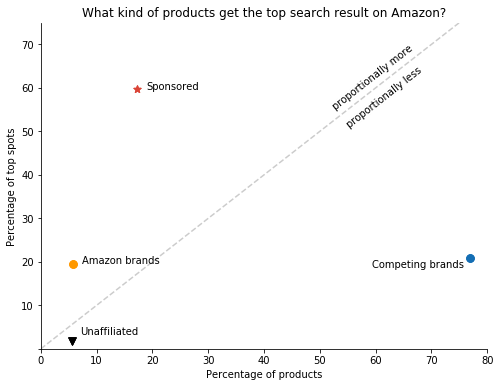

In [31]:
cats = [
    'Sponsored',
    'Amazon brands', 
    'Competing brands',
    'Unaffiliated'
]
plt.figure(figsize=(8, 6))
plt.title("What kind of products get the top search result on Amazon?")
ax = plt.gca()

to_plot = res[res.Category.isin(cats)]
to_plot.to_csv(fig2_csv)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_ylabel('Percentage of top spots')
ax.set_xlabel('Percentage of products')

ax.set_ylim(0, 75)
ax.set_xlim(0, 80) 
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)

for kind in cats:
    d = to_plot[to_plot.Category==kind]
    if kind in ['Unaffiliated']:
        ax.annotate(kind, (d['Perc Products'] + 1.5,
                       d['Perc #1 spot'] + 1.5))
    elif kind == 'Competing brands':
        ax.annotate(kind, (d['Perc Products'] - 17.5,
                       d['Perc #1 spot'] - 2))
    else:
        ax.annotate(kind, (d['Perc Products'] + 1.6,
                           d['Perc #1 spot']))
    for j in range(1,6):
        plt.scatter(x=d['Perc Products'],
                    y=d['Perc #1 spot'],
                    c=cat2color[kind],
                    s=55,
                    alpha=.2 * j,
                    label=kind,
                    marker = mkr_dict[kind]['marker'])

            
ax.plot([0, 100], [0, 100],  '--', alpha=.4, color='grey')
ax.annotate("proportionally more", 
            (52, 55), rotation=38)
ax.annotate("proportionally less", 
            (54.5, 51), rotation=38)

plt.savefig(fig2);

## Heatmap

In [32]:
def heatmap(df, control, cmap, title, vmin=0, vmax=100, fn_out=None):
    """Produces a heatmap of product slots"""
    amzn_label = (df
        .product_order.value_counts()
        .sort_index()
        .reindex(pd.RangeIndex(1, 61))[::-1])
    amzn_label = amzn_label / control * 100
    if fn_out:
        amzn_label.to_csv(fn_out)
        
    amzn_label_grid = amzn_label.iloc[::-1].values.reshape(15, 4)
    amzn_label_grid = pd.DataFrame(amzn_label_grid)
    amzn_label_grid.index = [_ + 1 for _ in amzn_label_grid.index]
    amzn_label_grid.columns = [_ + 1 for _ in amzn_label_grid.columns]

    fig = plt.figure(figsize=(6,12))
    sns.heatmap(amzn_label_grid,
                linewidths=4,
                fmt='g',
                cmap=cmap,
                vmin=vmax,
                vmax=vmin)
    plt.title(title)
    plt.ylabel("⟵ Rows of products going down the page")
    plt.xlabel("Columns of products across the page")
    plt.yticks(rotation=0)
    
    return fig

In [23]:
df_s = df[df.is_sponsored == True]
df_ns = df[df.is_sponsored == False]

df_non_amazon = df_ns[(~df_ns.asin.isin(amazon_asin))]
df_amazon_brand_ = df_ns[df_ns.asin.isin(amazon_asin)]


df_non_amazon_ = df_ns[
    (~df_ns.asin.isin(amazon_asin))
  & (df_ns.is_sold_by_amazon == False)
  & (df_ns.is_shipped_by_amazon == False)
  & (df_ns.is_prime == False) 
  & (df_ns.is_fresh == False)
]

In [33]:
control = (df.product_order.value_counts()
    .sort_index()
    .reindex(pd.RangeIndex(1, 61))[::-1])

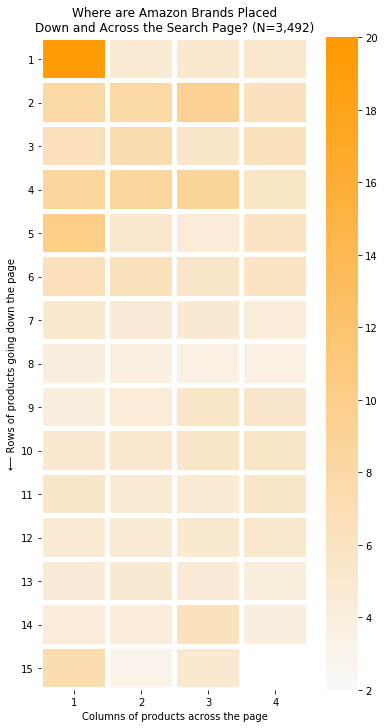

In [34]:
cmap = LinearSegmentedColormap.from_list(
    'mycmap', ['#f9f9f9', "#ff9900"]
)
fig = heatmap(
    df_amazon_brand_, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', "#ff9900"]),
    title=f"Where are Amazon Brands Placed\nDown and Across the Search Page? (N={n_samples:,})",
    vmax=20, vmin=2, fn_out=fig3a_csv
)
fig.savefig(fig3a);

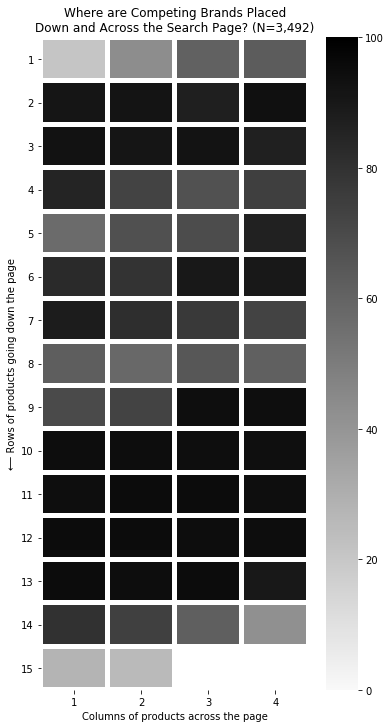

In [35]:
fig = heatmap(
    df_non_amazon, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', 'black']),
    title=f"Where are Competing Brands Placed\nDown and Across the Search Page? (N={n_samples:,})",
)

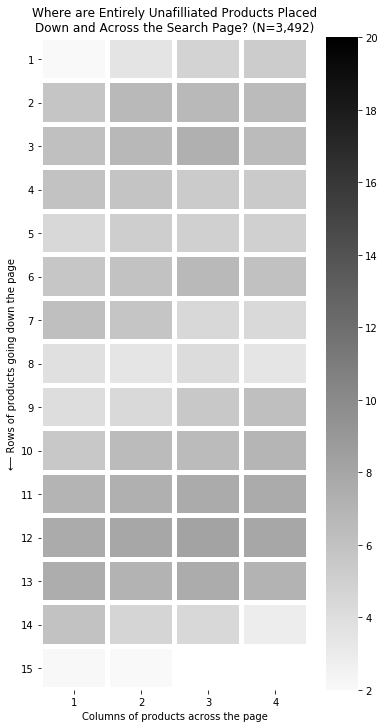

In [36]:
fig = heatmap(
    df_non_amazon_, control,
    cmap = LinearSegmentedColormap.from_list(None, ['#f9f9f9', 'black']),
    title=f"Where are Entirely Unafilliated Products Placed\nDown and Across the Search Page? (N={n_samples:,})",
    vmin=2, vmax=20, fn_out=fig3b_csv
)
fig.savefig(fig3b)

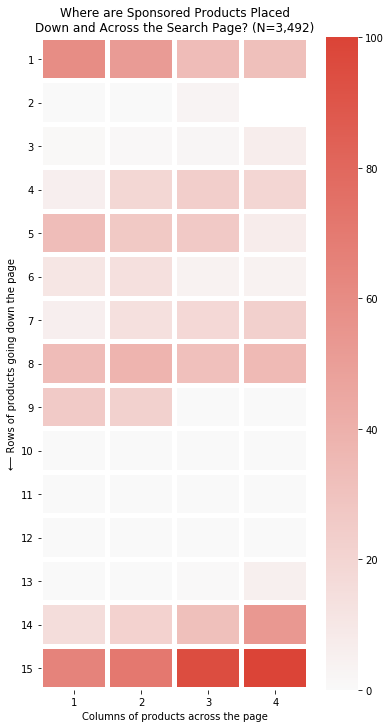

In [37]:
fig = heatmap(
    df_s, control, 
    cmap=LinearSegmentedColormap.from_list(None, ['#f9f9f9', '#DB4437']),
    title=f"Where are Sponsored Products Placed\nDown and Across the Search Page? (N={n_samples:,})",
    fn_out=fig3c_csv
)
fig.savefig(fig3c)

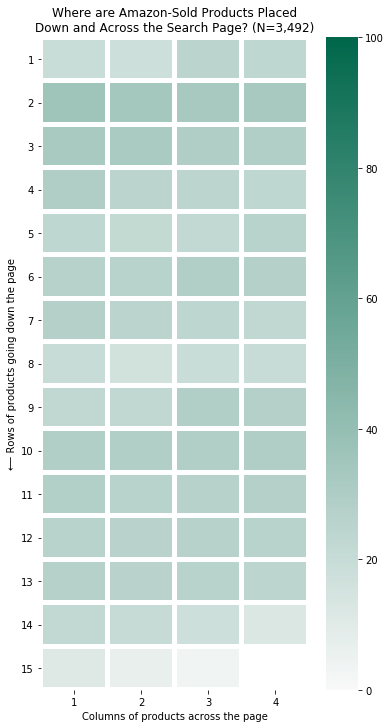

In [38]:
fig = heatmap(
    df_amazon_sold_, control, 
    cmap=LinearSegmentedColormap.from_list(None, ['#f9f9f9', '#00674b']),
    title=f"Where are Amazon-Sold Products Placed\nDown and Across the Search Page? (N={n_samples:,})"
)

## Not Clearly Labelled

In [43]:
# How many asins are Featured from our brands
(df[df.is_featured_brand == True].asin.nunique() / 
df[df.asin.isin(amazon_asin)].asin.nunique())

0.26088429612061664

In [44]:
# How many asins are Featured from our brands
(len(df[df.is_featured_brand == True]) / 
len(df[df.asin.isin(amazon_asin)]))

0.1962855382448728

In [45]:
amazon_missed_all = '|'.join([
    'amazon basics',
    'amazon essentials',
    'whole foods market',
    'amazon commercial',
    'amazon collection',
    'amazon fresh',
    'amazon elements',
    'amazonbasics'
    '365 everyday value',
    'amazon exclusive',
    'amazon us exclusive',
    'amazon brand'
])

amazon_missed = '|'.join([
    'amazon basics',
    'amazon essentials',
    'whole foods market',
    'amazon commercial',
    'amazon collection',
    'amazon fresh',
    'amazon elements',
    'amazonbasics'
    '365 everyday value',
])

amazon_disclaimer = '|'.join([
    'amazon exclusive',
    'amazon us exclusive',
    'amazon brand'
])

In [71]:
# How many contain a disclaimer
disclaimer = (df[
  ((df.is_featured_brand) | 
   (df.product_name.str.contains(amazon_disclaimer, case=False))) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 
df[df.asin.isin(amazon_asin)].asin.nunique())

disclaimer

0.4204641707606302

In [72]:
# how many items contains a name with known brand
known_brand = (df[
  (df.product_name.str.contains(amazon_missed, case=False)) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 
df[df.asin.isin(amazon_asin)].asin.nunique())

known_brand

0.2475012705404032

In [73]:
# How many do not contain a disclaimer or well known brand?
not_labelled = 1- (df[
  ((df.product_name.str.contains(amazon_missed_all, case=False)) | 
   (df.is_featured_brand)) &
  (df.asin.isin(amazon_asin))
].asin.nunique() / 
df[df.asin.isin(amazon_asin)].asin.nunique())

not_labelled

0.4089446044384212

In [81]:
t1 = pd.DataFrame([
    {"" : "Labelled with a Disclaimer", "percentage": disclaimer},
    {"" : "Well-Known Amazon private label", "percentage": known_brand},
    {"" : "Total Labelled", "percentage": 1-not_labelled},
    {"" : "Total Unlabelled", "percentage": not_labelled},
])
t1.to_csv(table1, index=False)
t1

,,percentage
0,Labelled with a Disclaimer,0.420464
1,Well-Known Amazon private label,0.247501
2,Total Labelled,0.591055
3,Total Unlabelled,0.408945


In [49]:
# perc of top amazon products with a "featured from our brands" tag
(df[
    (df.is_featured_brand) &
    (df.asin.isin(amazon_asin)) &
    (df.product_order == 1)
].search_term.nunique()) / df[(df.asin.isin(amazon_asin)) & (df.product_order == 1)].search_term.nunique()

0.8387978142076503

## More Stars and reviews?

In [50]:
if not os.path.exists(fn_compare):   
    data = []
    for st, _df in tqdm(df[df.is_sponsored == False].groupby("search_term")):
        _df.sort_values(by='product_order')
        amzn = _df[_df.asin.isin(amazon_asin)]
        non_amzn = _df[~_df.asin.isin(amazon_asin)]
        wnon_amzn =_df[
            (~_df.asin.isin(amazon_asin)) &
            (_df.is_sold_by_amazon == False) &
            (_df.is_fresh == False) &
            (_df.is_prime == False)
        ]

        if not amzn.empty:
            top_amazon =  amzn.product_order.iloc[0]
            amazon_star = amzn.stars.iloc[0]
            amazon_review = amzn.reviews.iloc[0]
        else:
            top_amazon = np.nan
            amazon_star = np.nan
            amazon_review = np.nan

        if not non_amzn.empty:    
            top_non_amazon_brand = non_amzn.product_order.iloc[0]
            non_amazon_star = non_amzn.stars.iloc[0]
            non_amazon_review = non_amzn.reviews.iloc[0]
        else:
            top_non_amazon = np.nan
            non_amazon_star = np.nan
            non_amazon_review = np.nan

        if not wnon_amzn.empty:
            top_wnon_amazon = wnon_amzn.product_order.iloc[0]
            wnon_amazon_star = wnon_amzn.stars.iloc[0]
            wnon_amazon_review = wnon_amzn.reviews.iloc[0]

        else:
            top_wnon_amazon = np.nan
            wnon_amazon_star = np.nan
            wnon_amazon_review = np.nan
        record = {
            "search_term": st,
            "position_first_amazon": top_amazon,
            "position_first_non_amazon": top_non_amazon_brand,
            "position_first_wholly_non_amazon": top_wnon_amazon,

            "amazon_stars": amazon_star,
            "amazon_reviews": amazon_review,

            "non_amazon_stars": non_amazon_star,
            "non_amazon_reviews": non_amazon_review,

            "wnon_amazon_stars": wnon_amazon_star,
            "wnon_amazon_reviews": wnon_amazon_review,
        }
        data.append(record)
    df_compare = pd.DataFrame(data)
    df_compare.to_csv(fn_compare, index=False)
    
else:
    df_compare = pd.read_csv(fn_compare)

In [51]:
len(df_compare[df_compare.position_first_amazon < df_compare.position_first_non_amazon]) / len(df_compare)

0.22880870561282932

In [52]:
# how many Amazon products have more stars
df_compare[
    df_compare.position_first_amazon < df_compare.position_first_non_amazon
].apply(
    lambda x:
    x['amazon_stars'] > x['non_amazon_stars'],
    axis=1
).value_counts(normalize=True)

False    0.653317
True     0.346683
dtype: float64

In [53]:
# how many Amazon products have more reivews than the
df_compare[
    (df_compare.position_first_amazon < df_compare.position_first_non_amazon) &
    (~df_compare.non_amazon_reviews.isnull())
].apply(
    lambda x:
    x['amazon_reviews'] > x['non_amazon_reviews'],
    axis=1
).value_counts(normalize=True)

False    0.517241
True     0.482759
dtype: float64

In [54]:
# how many Amazon products have more reivews than the
df_compare[
    (df_compare.position_first_amazon < df_compare.position_first_non_amazon) &
    (~df_compare.non_amazon_reviews.isnull())
].apply(
    lambda x:
    (x['amazon_reviews'] < x['non_amazon_reviews']) and 
    (x['amazon_stars'] < x['non_amazon_stars']),
    axis=1
).value_counts(normalize=True)

False    0.720307
True     0.279693
dtype: float64

In [55]:
# duplicates
asins_by_search = df[df.is_sponsored == False].groupby('search_term').asin.value_counts()

In [56]:
# perc_searches_dupluicate_asin
asins_by_search[asins_by_search > 1].index.get_level_values(0).nunique() / df.search_term.nunique()

0.09221076746849943

In [57]:
# how many of these duplicates are Amazon products?
duplicate_asin = asins_by_search[asins_by_search > 1].index.get_level_values(1)
len([_ for _ in duplicate_asin if _ in amazon_asin]) / len(duplicate_asin)

1.0

## Supplementary dataset

In [58]:
df_generic.search_term.nunique()

1217

In [59]:
table_generic = calculate_table_not_unique(df_generic, amazon_asin)
table_generic

,Category,Perc Products,Perc #1 spot,Perc first row
0,Unaffiliated,2.847576,0.657354,3.533279
1,Amazon brands,8.225208,24.897288,35.332786
2,Competing brands,73.530388,10.764174,54.478225
3,Sponsored,18.244404,64.338537,84.223500
4,Amazon sold,24.640986,21.281841,44.124897
5,Third-party sold,57.114610,14.379622,49.219392
6,Amazon shipped,78.765136,34.921939,70.172555


In [60]:
table_top = calculate_table_not_unique(df_top, amazon_asin)
table_top

,Category,Perc Products,Perc #1 spot,Perc first row
0,Unaffiliated,5.526465,1.746850,7.731959
1,Amazon brands,5.801081,19.530355,24.770905
2,Competing brands,76.880992,20.819015,63.516609
3,Sponsored,17.317926,59.650630,75.286369
4,Amazon sold,24.729382,19.473081,42.353952
5,Third-party sold,57.952691,20.876289,52.577320
6,Amazon shipped,76.966310,38.487973,72.565865


In [61]:
df[df.is_amazon == True].asin.nunique() / df[(df.product_order == 1) & (df.is_amazon == True)].search_term.nunique()

8.064207650273223

In [62]:
df[df.is_amazon != True].asin.nunique() / df[(df.product_order == 1) & (df.is_amazon != True)].search_term.nunique()

43.42971014492753

In [63]:
df[(df.product_order == 1) & (df.is_amazon == True)].search_term.nunique()

732

In [64]:
table_diff = table_generic.set_index('Category').subtract(
    table_top.set_index('Category'))

In [65]:
comparison = pd.concat([
    table_top[['Category', 'Perc Products',  'Perc #1 spot']].set_index('Category'), 
    table_generic[['Category','Perc Products',  'Perc #1 spot']].set_index('Category'),
], axis=1, keys=["top", "generic"])

In [66]:
comparison

top                    generic             
                 Perc Products Perc #1 spot Perc Products Perc #1 spot
Category                                                              
Unaffiliated          5.526465     1.746850      2.847576     0.657354
Amazon brands         5.801081    19.530355      8.225208    24.897288
Competing brands     76.880992    20.819015     73.530388    10.764174
Sponsored            17.317926    59.650630     18.244404    64.338537
Amazon sold          24.729382    19.473081     24.640986    21.281841
Third-party sold     57.952691    20.876289     57.114610    14.379622
Amazon shipped       76.966310    38.487973     78.765136    34.921939

In [67]:
# comparison = comparison.swaplevel(0, 1, 1).sort_index(1)

In [68]:
comparison.round(1).to_csv(table4)

## Sankey

In [69]:
print(json.dumps({
    "nodes":[
        {"name":"All Products","node":0},
        {"name":"Sponsored","node":1},   
        {"name":"Organic","node":2},   
        {"name":"Amazon Sold","node":3},
        {"name":"Third-party Sold","node":4},
        {"name":"Amazon Brands","node":5},
        {"name":"Competing Brands","node":6}
    ],
    "links":[
        {"source":0,"target":1,"value":len(df_s)},
        {"source":0,"target":2,"value":len(df_ns)},  
        {"source":2,"target":3,"value":len(df_amazon_sold_)},
        {"source":2,"target":4,"value":len(df_not_amazon_sold_)},    
        {"source":3,"target":5,"value":len(df_amazon_sold_[df_amazon_sold_.asin.isin(amazon_asin)])},
        {"source":3,"target":6, "value":len(df_amazon_sold_[~df_amazon_sold_.asin.isin(amazon_asin)])},
        {"source":4,"target":5,"value":len(df_not_amazon_sold_[df_not_amazon_sold_.asin.isin(amazon_asin)])},
        {"source":4,"target":6,"value":len(df_not_amazon_sold_[~df_not_amazon_sold_.asin.isin(amazon_asin)])},
    ]
}))

{"nodes": [{"name": "All Products", "node": 0}, {"name": "Sponsored", "node": 1}, {"name": "Organic", "node": 2}, {"name": "Amazon Sold", "node": 3}, {"name": "Third-party Sold", "node": 4}, {"name": "Amazon Brands", "node": 5}, {"name": "Competing Brands", "node": 6}], "links": [{"source": 0, "target": 1, "value": 32477}, {"source": 0, "target": 2, "value": 155057}, {"source": 2, "target": 3, "value": 46376}, {"source": 2, "target": 4, "value": 108681}, {"source": 3, "target": 5, "value": 7057}, {"source": 3, "target": 6, "value": 39319}, {"source": 4, "target": 5, "value": 3822}, {"source": 4, "target": 6, "value": 104859}]}
